In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt')]

# Data

In [4]:
img_fns = get_image_files(path/'images'); img_fns[:2]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0006R0_f01020.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06390.png')]

In [5]:
mask_fns = get_image_files(path/'labels'); mask_fns[:2]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f02340_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01230_P.png')]

In [6]:
def get_mask_fn(img_fn): return f'{path}/labels/{img_fn.stem}_P.png'

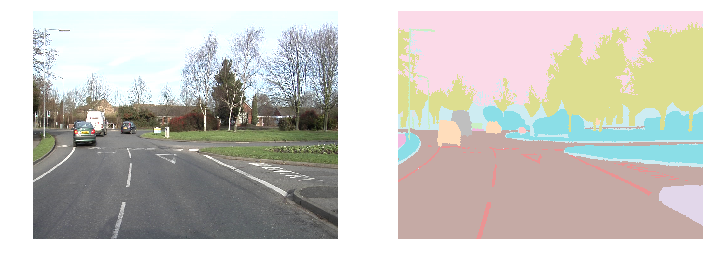

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
open_image(img_fns[0]).show(ax=axes[0])
open_mask(get_mask_fn(img_fns[0])).show(ax=axes[1])

In [8]:
img = open_image(img_fns[0])
src_size = np.array(img.size); src_size

array([720, 960])

# Datasets

In [9]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [10]:
data_src = (SegmentationItemList.from_folder(path/'images')
           .split_by_fname_file('valid.txt', path=path)
           .label_from_func(get_mask_fn, classes=codes))

In [11]:
tfms = get_transforms()

# Small model

In [12]:
size = src_size // 2; size

array([360, 480])

In [13]:
bs = 8

In [14]:
db = (data_src.transform(tfms, tfm_y=True, size=size)
     .databunch(bs=bs)
     .normalize(imagenet_stats))

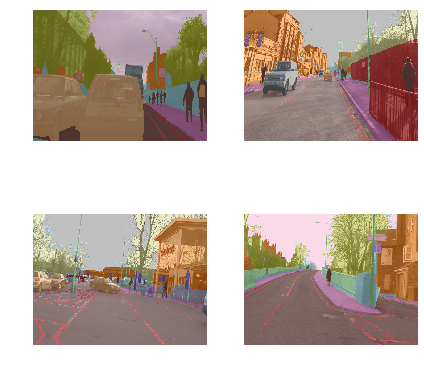

In [20]:
db.show_batch(2, figsize=(6,6))

In [15]:
camvid_acc = partial(foreground_acc, void_code=list(codes).index('Void'))

In [21]:
learn = unet_learner(db, models.resnet34, metrics=[camvid_acc])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


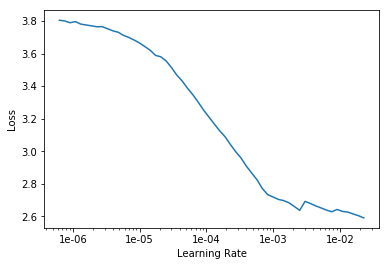

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr = 6e-4
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,time
0,1.395766,0.875283,0.804392,00:56
1,0.890914,0.718742,0.802468,00:53
2,0.702225,0.610341,0.835452,00:52
3,0.621681,0.436159,0.870638,00:52
4,0.527078,0.393673,0.882131,00:52
5,0.460947,0.380242,0.893967,00:52
6,0.422435,0.340952,0.900236,00:52
7,0.387526,0.330113,0.903315,00:53
8,0.352524,0.303373,0.910235,00:53
9,0.334503,0.301445,0.912452,00:53


In [24]:
learn.save('r34-small-stage1')

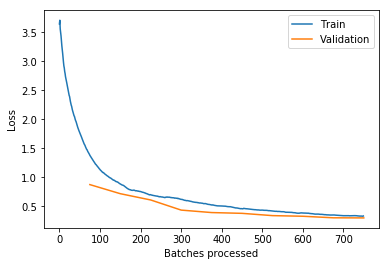

In [26]:
learn.recorder.plot_losses()

Note: We could have gone with a larger learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


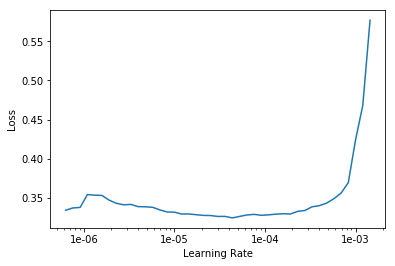

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(8, slice(1e-5, lr/2))

epoch,train_loss,valid_loss,foreground_acc,time
0,0.325551,0.309039,0.912076,00:54
1,0.351837,0.353213,0.890117,00:54
2,0.360112,0.333733,0.901333,00:54
3,0.340327,0.349949,0.897011,00:54
4,0.313576,0.306932,0.907074,00:54
5,0.287384,0.282333,0.917884,00:54
6,0.263546,0.285328,0.916017,00:54
7,0.251392,0.283312,0.917674,00:55


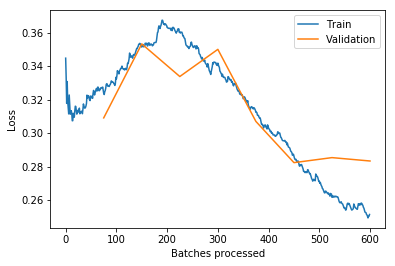

In [30]:
learn.recorder.plot_losses()

Note: Too high learning rate!

In [31]:
learn.save('r34-small-stage2')

# Let's go big

In [16]:
size = src_size
bs = 2

In [17]:
db = (data_src.transform(tfms, tfm_y=True, size=size)
      .databunch(bs=bs)
      .normalize(imagenet_stats))
learn = unet_learner(db, models.resnet34, metrics=[camvid_acc])
learn.load('r34-small-stage2');

In [22]:
learn.freeze()

In [24]:
learn.lr_find()

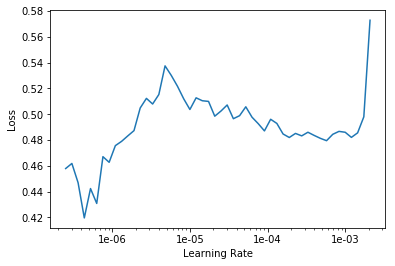

In [30]:
learn.recorder.plot(skip_start=5, skip_end=4)

In [31]:
lr = 3e-4

In [32]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,time
0,0.376518,0.346586,0.897890,03:31
1,0.381958,0.316572,0.903921,03:28
2,0.419035,0.399001,0.884235,03:28
3,0.377788,0.295243,0.913971,03:28
4,0.319974,0.312382,0.912415,03:28
5,0.299358,0.268080,0.924993,03:28
6,0.265353,0.307637,0.920450,03:28
7,0.225189,0.271564,0.926996,03:28
8,0.218461,0.255873,0.929255,03:28
9,0.213730,0.251530,0.930315,03:28


In [33]:
learn.save('r34-big-stage1');

In [34]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


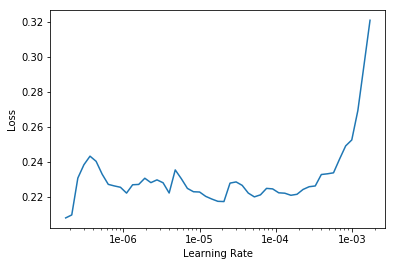

In [36]:
learn.recorder.plot(skip_start=3)

In [37]:
learn.fit_one_cycle(8, slice(5e-6, lr/10))

epoch,train_loss,valid_loss,foreground_acc,time
0,0.207878,0.251522,0.930033,03:35
1,0.216713,0.248598,0.929154,03:35
2,0.203370,0.250930,0.930549,03:35
3,0.204935,0.249384,0.930748,03:35
4,0.208961,0.257449,0.927760,03:35
5,0.194884,0.242978,0.931424,03:35
6,0.177158,0.253928,0.930720,03:35
7,0.179190,0.250483,0.931347,03:35


In [38]:
learn.save('r34-big-stage2');

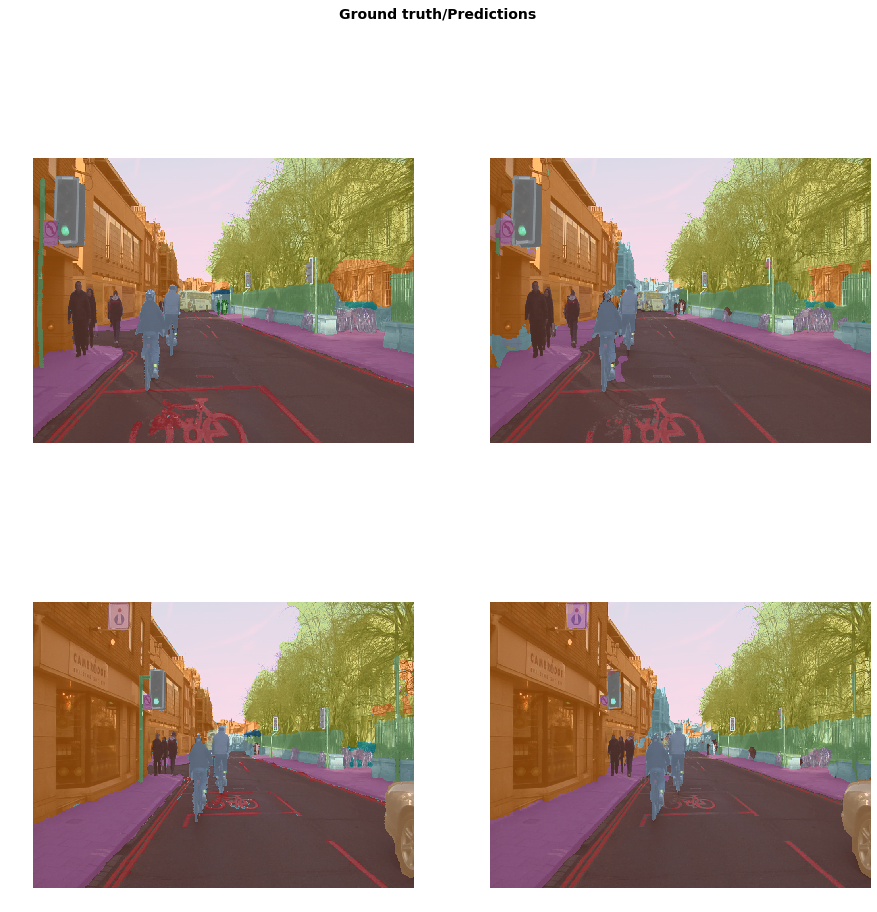

In [50]:
learn.show_results(rows=3, figsize=(15, 15))